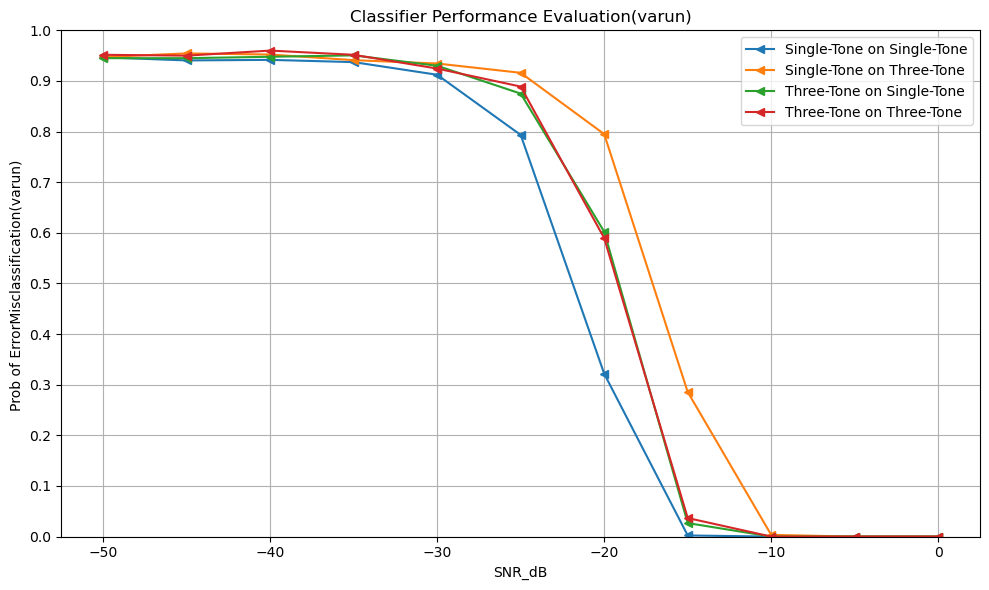

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SignalGenerator import SignalGenerator

class MelodyClassifier:
    def __init__(self, signal_generator):
        self.signal_generator = signal_generator

    def construct_H_matrix_single_tone(self, idx_melody, pitch_mismatch=1.0):
        melody = self.signal_generator.get_melody(idx_melody)
        K = self.signal_generator.nr_note_samples  # Full sample size
        K_div_10 = K // 10  # Reduced sample size (K/10)
        time_range = np.arange(K_div_10) / self.signal_generator.sampling_frequency  # Adjust time range for K/10 samples

        H_matrices = []
        for note in melody:
            f = self.signal_generator.note2frequency(note) * pitch_mismatch
            H = np.column_stack([np.cos(2 * np.pi * f * time_range), np.sin(2 * np.pi * f * time_range)])
            H_matrices.append(H)

        H_full = np.vstack(H_matrices)  # Stack matrices for all notes
        return H_full

    def single_tone_classifier(self, observed_melody, snr_db):
        nr_hypotheses = self.signal_generator.nr_hypotheses
        K = self.signal_generator.nr_note_samples  # Full sample size (3528)
        K_div_10 = K // 10  # Use K/10 samples
        pause_length = len(self.signal_generator.pause)  # Pause length (88 samples)
        N = len(self.signal_generator.get_melody(0))  # Number of notes in a melody

        errors = np.zeros(nr_hypotheses)

        for j in range(nr_hypotheses):
            idx_melody = j // 2  # Melody index
            pitch_mismatch = self.signal_generator.pitch_mismatches[j % 2]  # Pitch mismatch

            H_j = self.construct_H_matrix_single_tone(idx_melody, pitch_mismatch)

            for n in range(N):
                start_idx = n * (K + pause_length)  # Account for pause between notes
                end_idx = start_idx + K_div_10  # End index for K/10 samples

                if end_idx > len(observed_melody):
                    continue

                yn = observed_melody[start_idx:end_idx]  # Extract the n-th note signal
                H_n = H_j[n * K_div_10 : (n + 1) * K_div_10, :]  # The corresponding observation matrix block

                projection = H_n.T @ yn
                errors[j] += np.sum(yn**2) - (1 / K_div_10) * np.sum(projection**2)

        best_hypothesis = np.argmin(errors)  # Find the best hypothesis
        melody_index = best_hypothesis // 2
        pitch_mismatch = self.signal_generator.pitch_mismatches[best_hypothesis % 2]

        return melody_index, pitch_mismatch


    def construct_H_matrix_three_tone(self, idx_melody, pitch_mismatch=1.0):
        melody = self.signal_generator.get_melody(idx_melody)
        K = self.signal_generator.nr_note_samples
        K_div_10 = K // 10  # Reduced sample size (K/10)
        time_range = np.arange(K_div_10) / self.signal_generator.sampling_frequency

        H_matrices = []

        for note in melody:
            f = self.signal_generator.note2frequency(note) * pitch_mismatch

            # Three-tone model
            H = np.column_stack([
                np.cos(2 * np.pi * f * time_range), np.sin(2 * np.pi * f * time_range),
                np.cos(2 * np.pi * 3 * f * time_range), np.sin(2 * np.pi * 3 * f * time_range),
                np.cos(2 * np.pi * 5 * f * time_range), np.sin(2 * np.pi * 5 * f * time_range)
            ])
            H_matrices.append(H)

        H_full = np.vstack(H_matrices)
        return H_full

    def three_tone_classifier(self, observed_melody, snr_db):
        nr_hypotheses = self.signal_generator.nr_hypotheses
        K = self.signal_generator.nr_note_samples
        K_div_10 = K // 10  # Use K/10 samples
        pause_length = len(self.signal_generator.pause)
        N = len(self.signal_generator.get_melody(0))  # Number of notes in a melody

        errors = np.zeros(nr_hypotheses)

        for j in range(nr_hypotheses):
            idx_melody = j // 2  # Melody index
            pitch_mismatch = self.signal_generator.pitch_mismatches[j % 2]  # Pitch mismatch

            H_j = self.construct_H_matrix_three_tone(idx_melody, pitch_mismatch)

            for n in range(N):
                start_idx = n * (K + pause_length)
                end_idx = start_idx + K_div_10

                if end_idx > len(observed_melody):
                    continue

                yn = observed_melody[start_idx:end_idx]
                H_n = H_j[n * K_div_10 : (n + 1) * K_div_10, :]

                projection = H_n.T @ yn
                errors[j] += np.sum(yn**2) - (1 / K_div_10) * np.sum(projection**2)

        best_hypothesis = np.argmin(errors)
        melody_index = best_hypothesis // 2
        pitch_mismatch = self.signal_generator.pitch_mismatches[best_hypothesis % 2]

        return melody_index, pitch_mismatch

class PerformanceEvaluator:
    def __init__(self, signal_generator, single_tone_classifier, three_tone_classifier):
        self.signal_generator = signal_generator
        self.single_tone_classifier = single_tone_classifier
        self.three_tone_classifier = three_tone_classifier

    def evaluate_performance(self, scenario, snr_range, nr_trials=1800):
        error_rates = []

        for snr_db in snr_range:
            errors = 0

            for _ in range(nr_trials):
                if scenario == 1:  # Single-tone classifier on a single-tone melody
                    observed_melody, true_melody_idx, true_pitch_mismatch = self.signal_generator.generate_random_melody(snr_db, nr_tones=1)
                    predicted_melody_idx, predicted_pitch_mismatch = self.single_tone_classifier.single_tone_classifier(observed_melody, snr_db)

                elif scenario == 2:  # Single-tone classifier on a three-tone melody
                    observed_melody, true_melody_idx, true_pitch_mismatch = self.signal_generator.generate_random_melody(snr_db, nr_tones=3)
                    predicted_melody_idx, predicted_pitch_mismatch = self.single_tone_classifier.single_tone_classifier(observed_melody, snr_db)

                elif scenario == 3:  # Three-tone classifier on a single-tone melody
                    observed_melody, true_melody_idx, true_pitch_mismatch = self.signal_generator.generate_random_melody(snr_db, nr_tones=1)
                    predicted_melody_idx, predicted_pitch_mismatch = self.three_tone_classifier.three_tone_classifier(observed_melody, snr_db)

                elif scenario == 4:  # Three-tone classifier on a three-tone melody
                    observed_melody, true_melody_idx, true_pitch_mismatch = self.signal_generator.generate_random_melody(snr_db, nr_tones=3)
                    predicted_melody_idx, predicted_pitch_mismatch = self.three_tone_classifier.three_tone_classifier(observed_melody, snr_db)

                # Check if the classification is correct
                if predicted_melody_idx != true_melody_idx or predicted_pitch_mismatch != true_pitch_mismatch:
                    errors += 1

            # Calculate the error rate for this SNR
            error_rate = errors / nr_trials
            error_rates.append(error_rate)

        return error_rates

# Define the SNR range from -50 dB to 0 dB
snr_range = np.linspace(-50, 0, 11)  # From -50 to 0 dB in steps of 5 dB

# Initialize the SignalGenerator and MelodyClassifier
sg = SignalGenerator()
single_tone_classifier = MelodyClassifier(sg)
three_tone_classifier = MelodyClassifier(sg)

# Initialize the performance evaluator
evaluator = PerformanceEvaluator(sg, single_tone_classifier, three_tone_classifier)

# Collect error rates for each scenario
error_rates = {
    "Single-Tone on Single-Tone": evaluator.evaluate_performance(1, snr_range),
    "Single-Tone on Three-Tone": evaluator.evaluate_performance(2, snr_range),
    "Three-Tone on Single-Tone": evaluator.evaluate_performance(3, snr_range),
    "Three-Tone on Three-Tone": evaluator.evaluate_performance(4, snr_range),
}

# Plot the results with four curves
plt.figure(figsize=(10, 6))
for label, rates in error_rates.items():
    plt.plot(snr_range, rates, marker='<', label=label)

plt.title('Classifier Performance Evaluation(varun)')
plt.xlabel('SNR_dB')
plt.ylabel('Prob of ErrorMisclassification(varun) ')
plt.yscale('linear')  # Use a linear scale for the y-axis
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.grid(True)

# Customize y-ticks if needed
plt.yticks(np.arange(0, 1.1, 0.1), [f'{i:.1f}' for i in np.arange(0, 1.1, 0.1)])

plt.legend()
plt.tight_layout()
plt.show()
